In [ ]:
!pip install -q torch torchvision einops timm

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np, random, time, math, os
from tqdm import tqdm
from einops import rearrange

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device, torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

Device: cuda Tesla T4


In [ ]:
IMG_SIZE=32; PATCH=4
EMBED=256; DEPTH=6; HEADS=4; MLP_RATIO=4
DROP_PATH=0.1; LABEL_SMOOTH=0.1
LR=5e-4; WD=0.05; WARMUP=10; MIN_LR=1e-5
EPOCHS=200; BATCH=256; VAL_BATCH=2048
MIXUP_ALPHA=0.8; CUTMIX_ALPHA=1.0
MIXUP_PROB=0.5; CUTMIX_PROB=0.5
ema_decay=0.9997

In [ ]:
normalize = transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=1, magnitude=7),
    transforms.ToTensor(), normalize,
])
test_tfms = transforms.Compose([transforms.ToTensor(), normalize])

trainset = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=train_tfms)
testset  = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=test_tfms)

train_size = int(0.9*len(trainset))
val_size   = len(trainset)-train_size
train_ds, val_ds = random_split(trainset, [train_size,val_size], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
valloader   = DataLoader(val_ds, batch_size=VAL_BATCH, shuffle=False, num_workers=2, pin_memory=True)
testloader  = DataLoader(testset, batch_size=VAL_BATCH, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 170M/170M [01:46<00:00, 1.61MB/s]


In [ ]:
class PatchEmbed(nn.Module):
    def __init__(self, img=32, patch=4, in_ch=3, dim=256):
        super().__init__()
        self.proj=nn.Conv2d(in_ch,dim,kernel_size=patch,stride=patch)
        self.num_patches=(img//patch)**2
    def forward(self,x):
        x=self.proj(x)
        return x.flatten(2).transpose(1,2)

class MLP(nn.Module):
    def __init__(self,dim,mlp_ratio=4,drop=0.1):
        super().__init__()
        hidden=int(dim*mlp_ratio)
        self.fc1=nn.Linear(dim,hidden); self.act=nn.GELU()
        self.fc2=nn.Linear(hidden,dim); self.drop=nn.Dropout(drop)
    def forward(self,x): return self.drop(self.fc2(self.drop(self.act(self.fc1(x)))))

class Block(nn.Module):
    def __init__(self,dim,heads,mlp_ratio=4,drop=0.1,drop_path=0.0):
        super().__init__()
        self.norm1=nn.LayerNorm(dim)
        self.attn=nn.MultiheadAttention(dim,heads,batch_first=True,dropout=drop)
        self.norm2=nn.LayerNorm(dim); self.mlp=MLP(dim,mlp_ratio,drop)
        self.drop_path=drop_path
    def forward(self,x):
        h=x; x=self.norm1(x); x,_=self.attn(x,x,x)
        if self.training and self.drop_path>0:
            keep=1-self.drop_path
            mask=(torch.rand((x.size(0),)+(1,)*(x.ndim-1),device=x.device)<keep).float()
            x=x/keep*mask
        x=h+x; h=x; x=self.norm2(x); x=self.mlp(x)
        return h+x

class ViT(nn.Module):
    def __init__(self,img=32,patch=4,dim=256,depth=6,heads=4,num_classes=10,drop_path_rate=0.1):
        super().__init__()
        self.patch_embed=PatchEmbed(img,patch,3,dim)
        num_patches=self.patch_embed.num_patches
        self.cls_token=nn.Parameter(torch.zeros(1,1,dim))
        self.pos_embed=nn.Parameter(torch.zeros(1,num_patches+1,dim))
        self.blocks=nn.Sequential(*[Block(dim,heads,MLP_RATIO,drop=0.1,drop_path=drop_path_rate) for _ in range(depth)])
        self.norm=nn.LayerNorm(dim)
        self.head=nn.Linear(dim,num_classes)
        nn.init.trunc_normal_(self.pos_embed,std=0.02)
        nn.init.trunc_normal_(self.cls_token,std=0.02)
    def forward(self,x):
        x=self.patch_embed(x); B=x.size(0)
        cls=self.cls_token.expand(B,-1,-1)
        x=torch.cat((cls,x),1)+self.pos_embed
        x=self.blocks(x); x=self.norm(x)
        return self.head(x[:,0])

model=ViT().to(device)

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=10, smoothing=0.1):
        super().__init__()
        self.conf = 1.0 - smoothing
        self.smooth = smoothing / (classes - 1)

    def forward(self, pred, target):
        true_dist = torch.full_like(pred, self.smooth)
        true_dist.scatter_(1, target.unsqueeze(1), self.conf)
        return torch.mean(torch.sum(-true_dist * F.log_softmax(pred, dim=1), dim=1))

criterion = LabelSmoothingLoss(10, LABEL_SMOOTH)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WD, betas=(0.9, 0.999))

warmup = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=1e-3, end_factor=1.0, total_iters=WARMUP
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=EPOCHS - WARMUP, eta_min=MIN_LR
)

scaler = torch.amp.GradScaler("cuda")

In [ ]:
@torch.no_grad()
def evaluate(loader):
    model.eval()
    loss_sum, correct, n = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.amp.autocast("cuda"):
            out = model(x)
            loss = criterion(out, y)
        loss_sum += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        n += x.size(0)
    return loss_sum / n, correct / n

print("Training")

H = {
    "train_loss": [], "train_acc": [],
    "val_loss": [],   "val_acc": [],
    "lr": [],         "epoch_time": []
}
best = 0.0

for ep in range(1, EPOCHS + 1):
    model.train()
    t0 = time.time()
    total, correct, loss_sum = 0, 0, 0.0

    for x, y in tqdm(trainloader, leave=False):
        x, y = x.to(device), y.to(device)

        with torch.amp.autocast("cuda"):
            out = model(x)
            loss = criterion(out, y)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        bs = y.size(0)
        total += bs
        correct += (out.argmax(1) == y).sum().item()
        loss_sum += loss.item() * bs

    if ep <= WARMUP:
        warmup.step()
    else:
        scheduler.step()

    tr_loss, tr_acc = loss_sum / total, correct / total
    vl_loss, vl_acc = evaluate(valloader)

    H["train_loss"].append(tr_loss)
    H["train_acc"].append(tr_acc)
    H["val_loss"].append(vl_loss)
    H["val_acc"].append(vl_acc)
    H["lr"].append(optimizer.param_groups[0]["lr"])
    H["epoch_time"].append(time.time() - t0)

    if vl_acc > best:
        best = vl_acc
        torch.save(model.state_dict(), "best_vit.pth")

    print(f"epoch {ep:3d}/{EPOCHS} | "
          f"Train {tr_acc*100:5.2f}% | Val {vl_acc*100:5.2f}% | "
          f"LR {H['lr'][-1]:.6f} | Time {H['epoch_time'][-1]:.1f}s")


Training


epoch   1/200 | Train 55.43% | Val 56.62% | LR 0.000050 | Time 42.3s


epoch   2/200 | Train 57.76% | Val 59.66% | LR 0.000100 | Time 41.7s


epoch   3/200 | Train 58.30% | Val 60.06% | LR 0.000150 | Time 41.8s


epoch   4/200 | Train 58.89% | Val 61.66% | LR 0.000200 | Time 41.0s


epoch   5/200 | Train 58.93% | Val 60.22% | LR 0.000250 | Time 41.4s


epoch   6/200 | Train 59.22% | Val 60.96% | LR 0.000300 | Time 41.4s


epoch   7/200 | Train 59.68% | Val 60.88% | LR 0.000350 | Time 43.0s


epoch   8/200 | Train 59.85% | Val 63.04% | LR 0.000400 | Time 42.9s


epoch   9/200 | Train 60.52% | Val 62.02% | LR 0.000450 | Time 42.0s


epoch  10/200 | Train 60.97% | Val 63.68% | LR 0.000500 | Time 42.4s


epoch  11/200 | Train 61.21% | Val 64.22% | LR 0.000500 | Time 43.4s


epoch  12/200 | Train 63.03% | Val 64.76% | LR 0.000500 | Time 43.1s


epoch  13/200 | Train 63.67% | Val 63.88% | LR 0.000500 | Time 41.6s


epoch  14/200 | Train 64.90% | Val 67.66% | LR 0.000499 | Time 41.5s


epoch  15/200 | Train 65.99% | Val 68.68% | LR 0.000499 | Time 42.7s


epoch  16/200 | Train 66.80% | Val 68.24% | LR 0.000499 | Time 41.4s


epoch  17/200 | Train 67.63% | Val 69.04% | LR 0.000498 | Time 42.6s


epoch  18/200 | Train 68.58% | Val 67.80% | LR 0.000498 | Time 41.6s


epoch  19/200 | Train 69.50% | Val 70.48% | LR 0.000497 | Time 42.0s


epoch  20/200 | Train 69.60% | Val 70.64% | LR 0.000497 | Time 42.1s


epoch  21/200 | Train 70.71% | Val 71.14% | LR 0.000496 | Time 42.7s


epoch  22/200 | Train 71.29% | Val 72.06% | LR 0.000495 | Time 42.3s


epoch  23/200 | Train 71.69% | Val 72.70% | LR 0.000494 | Time 41.9s


epoch  24/200 | Train 72.26% | Val 72.84% | LR 0.000493 | Time 41.7s


epoch  25/200 | Train 72.94% | Val 72.80% | LR 0.000493 | Time 41.1s


epoch  26/200 | Train 73.41% | Val 73.70% | LR 0.000491 | Time 41.9s


epoch  27/200 | Train 73.90% | Val 74.16% | LR 0.000490 | Time 41.4s


epoch  28/200 | Train 74.45% | Val 74.30% | LR 0.000489 | Time 41.2s


epoch  29/200 | Train 75.31% | Val 75.16% | LR 0.000488 | Time 42.6s


epoch  30/200 | Train 75.50% | Val 75.06% | LR 0.000487 | Time 43.1s


epoch  31/200 | Train 75.79% | Val 75.54% | LR 0.000485 | Time 40.3s


epoch  32/200 | Train 76.25% | Val 74.68% | LR 0.000484 | Time 39.8s


epoch  33/200 | Train 76.62% | Val 76.82% | LR 0.000482 | Time 40.3s


epoch  34/200 | Train 77.17% | Val 75.60% | LR 0.000481 | Time 40.8s


epoch  35/200 | Train 77.42% | Val 76.94% | LR 0.000479 | Time 41.5s


epoch  36/200 | Train 77.96% | Val 77.20% | LR 0.000478 | Time 40.2s


epoch  37/200 | Train 78.30% | Val 76.90% | LR 0.000476 | Time 39.9s


epoch  38/200 | Train 78.50% | Val 77.94% | LR 0.000474 | Time 40.3s


epoch  39/200 | Train 78.93% | Val 77.82% | LR 0.000472 | Time 42.0s


epoch  40/200 | Train 79.16% | Val 78.14% | LR 0.000470 | Time 40.6s


epoch  41/200 | Train 79.58% | Val 79.00% | LR 0.000469 | Time 41.7s


epoch  42/200 | Train 79.69% | Val 79.04% | LR 0.000466 | Time 41.5s


epoch  43/200 | Train 80.41% | Val 79.20% | LR 0.000464 | Time 40.6s


epoch  44/200 | Train 80.72% | Val 78.84% | LR 0.000462 | Time 41.7s


epoch  45/200 | Train 80.85% | Val 79.44% | LR 0.000460 | Time 41.1s


epoch  46/200 | Train 81.07% | Val 78.88% | LR 0.000458 | Time 41.5s


epoch  47/200 | Train 81.38% | Val 78.00% | LR 0.000456 | Time 41.2s


epoch  48/200 | Train 81.83% | Val 78.72% | LR 0.000453 | Time 41.6s


epoch  49/200 | Train 82.25% | Val 79.30% | LR 0.000451 | Time 43.0s


epoch  50/200 | Train 82.12% | Val 79.78% | LR 0.000448 | Time 42.9s


epoch  51/200 | Train 82.52% | Val 79.36% | LR 0.000446 | Time 41.8s


epoch  52/200 | Train 82.85% | Val 79.28% | LR 0.000443 | Time 43.2s


epoch  53/200 | Train 83.17% | Val 79.58% | LR 0.000441 | Time 43.4s


epoch  54/200 | Train 83.53% | Val 79.12% | LR 0.000438 | Time 42.3s


epoch  55/200 | Train 83.81% | Val 79.94% | LR 0.000435 | Time 41.7s


epoch  56/200 | Train 84.02% | Val 80.30% | LR 0.000432 | Time 42.3s


epoch  57/200 | Train 84.23% | Val 79.70% | LR 0.000430 | Time 42.0s


epoch  58/200 | Train 84.37% | Val 81.00% | LR 0.000427 | Time 43.9s


epoch  59/200 | Train 84.67% | Val 80.32% | LR 0.000424 | Time 41.7s


epoch  60/200 | Train 85.13% | Val 80.94% | LR 0.000421 | Time 41.8s


epoch  61/200 | Train 85.04% | Val 80.58% | LR 0.000418 | Time 41.5s


epoch  62/200 | Train 85.47% | Val 81.82% | LR 0.000415 | Time 43.9s


epoch  63/200 | Train 85.60% | Val 80.68% | LR 0.000412 | Time 41.6s


epoch  64/200 | Train 85.63% | Val 81.00% | LR 0.000409 | Time 42.6s


epoch  65/200 | Train 85.89% | Val 80.20% | LR 0.000405 | Time 42.2s


epoch  66/200 | Train 86.15% | Val 81.40% | LR 0.000402 | Time 42.8s


epoch  67/200 | Train 86.32% | Val 81.98% | LR 0.000399 | Time 42.4s


epoch  68/200 | Train 86.64% | Val 81.34% | LR 0.000396 | Time 41.5s


epoch  69/200 | Train 86.66% | Val 81.68% | LR 0.000392 | Time 42.7s


epoch  70/200 | Train 87.03% | Val 81.58% | LR 0.000389 | Time 42.0s


epoch  71/200 | Train 87.27% | Val 81.80% | LR 0.000386 | Time 43.2s


epoch  72/200 | Train 87.33% | Val 81.82% | LR 0.000382 | Time 42.1s


epoch  73/200 | Train 87.50% | Val 82.40% | LR 0.000379 | Time 41.8s


epoch  74/200 | Train 87.63% | Val 80.78% | LR 0.000375 | Time 41.7s


epoch  75/200 | Train 88.01% | Val 81.92% | LR 0.000372 | Time 41.6s


epoch  76/200 | Train 88.28% | Val 81.74% | LR 0.000368 | Time 41.9s


epoch  77/200 | Train 88.35% | Val 82.08% | LR 0.000364 | Time 40.9s


epoch  78/200 | Train 88.40% | Val 81.74% | LR 0.000361 | Time 42.5s


epoch  79/200 | Train 88.67% | Val 82.10% | LR 0.000357 | Time 41.6s


epoch  80/200 | Train 88.87% | Val 81.80% | LR 0.000353 | Time 41.9s


epoch  81/200 | Train 89.15% | Val 81.68% | LR 0.000350 | Time 41.9s


epoch  82/200 | Train 89.18% | Val 82.18% | LR 0.000346 | Time 41.6s


epoch  83/200 | Train 89.15% | Val 81.40% | LR 0.000342 | Time 42.9s


epoch  84/200 | Train 89.48% | Val 81.88% | LR 0.000338 | Time 41.0s


epoch  85/200 | Train 89.60% | Val 82.44% | LR 0.000335 | Time 42.1s


epoch  86/200 | Train 89.66% | Val 82.00% | LR 0.000331 | Time 41.4s


epoch  87/200 | Train 89.58% | Val 81.72% | LR 0.000327 | Time 41.5s


epoch  88/200 | Train 89.85% | Val 80.96% | LR 0.000323 | Time 41.5s


epoch  89/200 | Train 90.58% | Val 81.74% | LR 0.000319 | Time 42.0s


epoch  90/200 | Train 90.33% | Val 82.38% | LR 0.000315 | Time 40.7s


epoch  91/200 | Train 90.71% | Val 82.52% | LR 0.000311 | Time 40.1s


epoch  92/200 | Train 90.31% | Val 82.70% | LR 0.000307 | Time 40.1s


epoch  93/200 | Train 90.73% | Val 82.28% | LR 0.000303 | Time 40.2s


epoch  94/200 | Train 90.77% | Val 82.80% | LR 0.000299 | Time 41.3s


epoch  95/200 | Train 91.19% | Val 82.52% | LR 0.000295 | Time 39.8s


epoch  96/200 | Train 91.19% | Val 82.60% | LR 0.000291 | Time 39.1s


epoch  97/200 | Train 91.27% | Val 82.94% | LR 0.000287 | Time 39.1s


epoch  98/200 | Train 91.41% | Val 83.42% | LR 0.000283 | Time 40.2s


epoch  99/200 | Train 91.43% | Val 82.64% | LR 0.000279 | Time 41.5s


epoch 100/200 | Train 91.69% | Val 83.22% | LR 0.000275 | Time 40.5s


epoch 101/200 | Train 91.78% | Val 83.16% | LR 0.000271 | Time 40.8s


epoch 102/200 | Train 92.02% | Val 83.16% | LR 0.000267 | Time 40.0s


epoch 103/200 | Train 92.19% | Val 83.36% | LR 0.000263 | Time 41.0s


epoch 104/200 | Train 92.23% | Val 83.42% | LR 0.000259 | Time 39.9s


epoch 105/200 | Train 92.27% | Val 82.64% | LR 0.000255 | Time 40.4s


epoch 106/200 | Train 92.44% | Val 82.30% | LR 0.000251 | Time 40.4s


epoch 107/200 | Train 92.46% | Val 82.82% | LR 0.000247 | Time 39.9s


epoch 108/200 | Train 92.58% | Val 83.58% | LR 0.000243 | Time 41.5s


epoch 109/200 | Train 92.65% | Val 84.18% | LR 0.000239 | Time 40.3s


epoch 110/200 | Train 92.96% | Val 83.34% | LR 0.000235 | Time 39.6s


epoch 111/200 | Train 93.00% | Val 82.74% | LR 0.000231 | Time 39.8s


epoch 112/200 | Train 92.79% | Val 83.42% | LR 0.000227 | Time 40.9s


epoch 113/200 | Train 92.99% | Val 83.98% | LR 0.000223 | Time 39.5s


epoch 114/200 | Train 93.57% | Val 83.38% | LR 0.000219 | Time 39.9s


epoch 115/200 | Train 93.32% | Val 83.22% | LR 0.000215 | Time 40.5s


epoch 116/200 | Train 93.53% | Val 83.96% | LR 0.000211 | Time 40.0s


epoch 117/200 | Train 93.45% | Val 83.20% | LR 0.000207 | Time 42.3s


epoch 118/200 | Train 93.49% | Val 83.82% | LR 0.000203 | Time 40.2s


epoch 119/200 | Train 93.54% | Val 83.56% | LR 0.000199 | Time 39.8s


epoch 120/200 | Train 93.70% | Val 84.08% | LR 0.000195 | Time 39.6s


epoch 121/200 | Train 93.69% | Val 83.16% | LR 0.000191 | Time 40.8s


epoch 122/200 | Train 94.02% | Val 84.74% | LR 0.000187 | Time 41.4s


epoch 123/200 | Train 94.17% | Val 83.88% | LR 0.000183 | Time 40.2s


epoch 124/200 | Train 94.21% | Val 84.06% | LR 0.000179 | Time 40.1s


epoch 125/200 | Train 94.14% | Val 83.66% | LR 0.000175 | Time 40.5s


epoch 126/200 | Train 94.27% | Val 83.44% | LR 0.000172 | Time 41.6s


epoch 127/200 | Train 94.37% | Val 84.82% | LR 0.000168 | Time 40.3s


epoch 128/200 | Train 94.50% | Val 84.62% | LR 0.000164 | Time 41.1s


epoch 129/200 | Train 94.37% | Val 84.10% | LR 0.000160 | Time 42.7s


epoch 130/200 | Train 94.58% | Val 83.64% | LR 0.000157 | Time 41.9s


epoch 131/200 | Train 94.61% | Val 83.44% | LR 0.000153 | Time 42.1s


epoch 132/200 | Train 94.85% | Val 84.26% | LR 0.000149 | Time 41.1s


epoch 133/200 | Train 94.77% | Val 84.60% | LR 0.000146 | Time 40.7s


epoch 134/200 | Train 95.05% | Val 83.72% | LR 0.000142 | Time 40.8s


epoch 135/200 | Train 95.14% | Val 84.04% | LR 0.000138 | Time 41.8s


epoch 136/200 | Train 94.95% | Val 84.02% | LR 0.000135 | Time 41.8s


epoch 137/200 | Train 95.12% | Val 84.74% | LR 0.000131 | Time 40.3s


epoch 138/200 | Train 95.27% | Val 84.44% | LR 0.000128 | Time 41.0s


epoch 139/200 | Train 95.35% | Val 84.54% | LR 0.000124 | Time 40.4s


epoch 140/200 | Train 95.42% | Val 83.72% | LR 0.000121 | Time 42.4s


epoch 141/200 | Train 95.51% | Val 83.94% | LR 0.000118 | Time 42.1s


epoch 142/200 | Train 95.51% | Val 84.50% | LR 0.000114 | Time 42.0s


epoch 143/200 | Train 95.53% | Val 85.16% | LR 0.000111 | Time 41.5s


epoch 144/200 | Train 95.57% | Val 83.84% | LR 0.000108 | Time 41.5s


epoch 145/200 | Train 95.49% | Val 84.32% | LR 0.000105 | Time 42.1s


epoch 146/200 | Train 95.88% | Val 84.12% | LR 0.000101 | Time 41.3s


epoch 147/200 | Train 95.84% | Val 84.90% | LR 0.000098 | Time 41.3s


epoch 148/200 | Train 95.71% | Val 84.92% | LR 0.000095 | Time 40.5s


epoch 149/200 | Train 95.98% | Val 84.46% | LR 0.000092 | Time 42.1s


epoch 150/200 | Train 96.05% | Val 85.00% | LR 0.000089 | Time 40.6s


epoch 151/200 | Train 95.95% | Val 85.12% | LR 0.000086 | Time 40.5s


epoch 152/200 | Train 96.11% | Val 84.92% | LR 0.000083 | Time 40.8s


epoch 153/200 | Train 96.15% | Val 84.72% | LR 0.000080 | Time 41.7s


epoch 154/200 | Train 96.10% | Val 85.08% | LR 0.000078 | Time 43.1s


epoch 155/200 | Train 96.15% | Val 84.58% | LR 0.000075 | Time 42.1s


epoch 156/200 | Train 96.38% | Val 85.64% | LR 0.000072 | Time 41.9s


epoch 157/200 | Train 96.15% | Val 84.66% | LR 0.000069 | Time 41.2s


epoch 158/200 | Train 96.27% | Val 85.66% | LR 0.000067 | Time 41.8s


epoch 159/200 | Train 96.45% | Val 84.62% | LR 0.000064 | Time 40.9s


epoch 160/200 | Train 96.32% | Val 84.92% | LR 0.000062 | Time 40.9s


epoch 161/200 | Train 96.46% | Val 84.94% | LR 0.000059 | Time 41.4s


epoch 162/200 | Train 96.42% | Val 85.24% | LR 0.000057 | Time 42.6s


epoch 163/200 | Train 96.50% | Val 85.16% | LR 0.000054 | Time 40.4s


epoch 164/200 | Train 96.55% | Val 85.50% | LR 0.000052 | Time 41.2s


epoch 165/200 | Train 96.76% | Val 85.42% | LR 0.000050 | Time 41.2s


epoch 166/200 | Train 96.65% | Val 85.60% | LR 0.000048 | Time 40.3s


epoch 167/200 | Train 96.73% | Val 84.88% | LR 0.000046 | Time 42.4s


epoch 168/200 | Train 96.68% | Val 85.20% | LR 0.000044 | Time 41.3s


epoch 169/200 | Train 96.70% | Val 84.96% | LR 0.000041 | Time 41.1s


epoch 170/200 | Train 96.70% | Val 85.10% | LR 0.000040 | Time 41.3s


epoch 171/200 | Train 96.81% | Val 84.96% | LR 0.000038 | Time 42.4s


epoch 172/200 | Train 96.88% | Val 85.30% | LR 0.000036 | Time 42.9s


epoch 173/200 | Train 96.82% | Val 85.88% | LR 0.000034 | Time 41.9s


epoch 174/200 | Train 96.99% | Val 85.76% | LR 0.000032 | Time 41.4s


epoch 175/200 | Train 96.90% | Val 85.92% | LR 0.000031 | Time 42.0s


epoch 176/200 | Train 97.03% | Val 85.30% | LR 0.000029 | Time 43.4s


epoch 177/200 | Train 97.05% | Val 86.02% | LR 0.000028 | Time 41.2s


epoch 178/200 | Train 97.00% | Val 84.84% | LR 0.000026 | Time 40.4s


epoch 179/200 | Train 97.10% | Val 85.50% | LR 0.000025 | Time 40.5s


epoch 180/200 | Train 97.06% | Val 85.44% | LR 0.000023 | Time 41.0s


epoch 181/200 | Train 97.13% | Val 85.28% | LR 0.000022 | Time 40.7s


epoch 182/200 | Train 97.12% | Val 85.46% | LR 0.000021 | Time 39.8s


epoch 183/200 | Train 97.07% | Val 85.44% | LR 0.000020 | Time 40.3s


epoch 184/200 | Train 97.15% | Val 85.48% | LR 0.000019 | Time 39.9s


epoch 185/200 | Train 97.09% | Val 86.40% | LR 0.000017 | Time 40.8s


epoch 186/200 | Train 97.01% | Val 85.72% | LR 0.000017 | Time 40.5s


epoch 187/200 | Train 97.14% | Val 85.28% | LR 0.000016 | Time 40.6s


epoch 188/200 | Train 97.12% | Val 85.24% | LR 0.000015 | Time 41.2s


epoch 189/200 | Train 97.27% | Val 85.04% | LR 0.000014 | Time 41.2s


epoch 190/200 | Train 97.11% | Val 85.22% | LR 0.000013 | Time 43.6s


epoch 191/200 | Train 97.19% | Val 85.50% | LR 0.000013 | Time 40.9s


epoch 192/200 | Train 97.26% | Val 85.18% | LR 0.000012 | Time 40.9s


epoch 193/200 | Train 97.27% | Val 85.94% | LR 0.000012 | Time 41.1s


epoch 194/200 | Train 97.16% | Val 85.50% | LR 0.000011 | Time 43.0s


epoch 195/200 | Train 97.22% | Val 85.20% | LR 0.000011 | Time 42.4s


epoch 196/200 | Train 97.15% | Val 85.28% | LR 0.000011 | Time 41.1s


epoch 197/200 | Train 97.06% | Val 85.46% | LR 0.000010 | Time 40.8s


epoch 198/200 | Train 97.25% | Val 85.70% | LR 0.000010 | Time 40.3s


epoch 199/200 | Train 97.31% | Val 84.78% | LR 0.000010 | Time 42.0s


epoch 200/200 | Train 97.28% | Val 85.20% | LR 0.000010 | Time 41.0s



Final Test: loss=0.8750, acc=87.58%


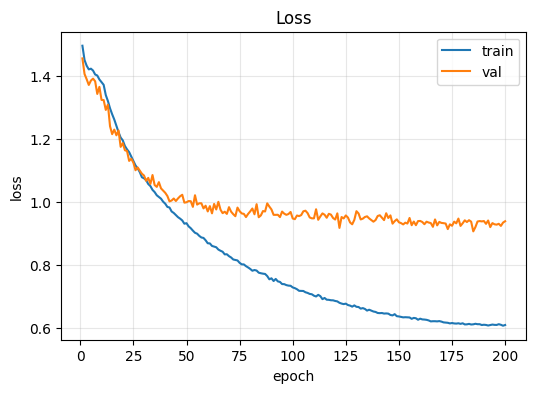

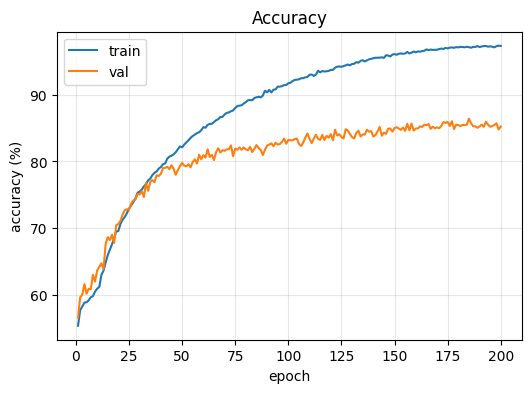

In [ ]:
model.load_state_dict(torch.load("best_vit.pth"))
test_loss, test_acc = evaluate(testloader)
print(f"\nFinal Test: loss={test_loss:.4f}, acc={test_acc*100:.2f}%")

import matplotlib.pyplot as plt
epochs = range(1, len(H["train_loss"]) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, H["train_loss"], label="train")
plt.plot(epochs, H["val_loss"],   label="val")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, [a*100 for a in H["train_acc"]], label="train")
plt.plot(epochs, [a*100 for a in H["val_acc"]],   label="val")
plt.xlabel("epoch"); plt.ylabel("accuracy (%)"); plt.title("Accuracy")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()